In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts



## Reading Data

In [17]:
# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = pd.read_csv('../../Data/data_preprocessed/predicition_data/P_agg_data_for_prediction.csv', engine='python', skipfooter=3)
df

,measurement,appliance,value,timestamp
0,Electricity,P_agg,105.183,1661990400
1,Electricity,P_agg,105.224,1661990430
2,Electricity,P_agg,106.171,1661990460
3,Electricity,P_agg,105.903,1661990490
4,Electricity,P_agg,105.970,1661990520
...,...,...,...,...
1049310,Electricity,P_agg,1029.913,1693526160
1049311,Electricity,P_agg,1030.499,1693526190
1049312,Electricity,P_agg,1030.900,1693526220
1049313,Electricity,P_agg,1028.714,1693526250


## First Approach

In [14]:
# Convert 'timestamp' to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Set datetime as index for resampling
df.set_index('datetime', inplace=True)

# Resample to daily sum of 'value' in kilowatts (kWh)
daily_df = df.resample('1D').mean(numeric_only=True)
daily_df['value'] = daily_df['value']   # Convert from Wh to kWh

# Reset index to turn datetime back into a column
daily_df = daily_df.reset_index()

# Add iteration column
daily_df['iteration'] = range(len(daily_df))

# Reorder columns
daily_df = daily_df[['iteration', 'datetime', 'value']]

# Final result
print(daily_df)

     iteration   datetime        value
0            0 2022-09-01   373.511802
1            1 2022-09-02  1152.774339
2            2 2022-09-03   763.151521
3            3 2022-09-04   915.743744
4            4 2022-09-05   116.932079
..         ...        ...          ...
360        360 2023-08-27   284.405375
361        361 2023-08-28   619.278530
362        362 2023-08-29   970.876859
363        363 2023-08-30   860.714743
364        364 2023-08-31   462.962759

[365 rows x 3 columns]


In [15]:
tseries= daily_df.drop('datetime', axis=1)
tseries = tseries.drop('iteration', axis=1)
df=pd.DataFrame(tseries)
df

,value
0,373.511802
1,1152.774339
2,763.151521
3,915.743744
4,116.932079
...,...
360,284.405375
361,619.278530
362,970.876859
363,860.714743


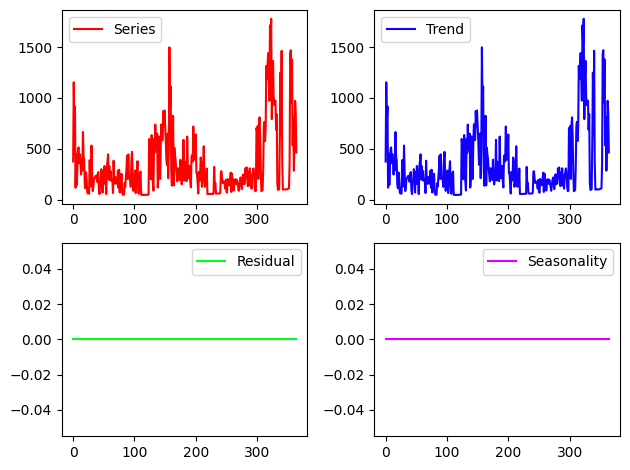

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(df['value'], model='additive', period=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(df['value'],color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

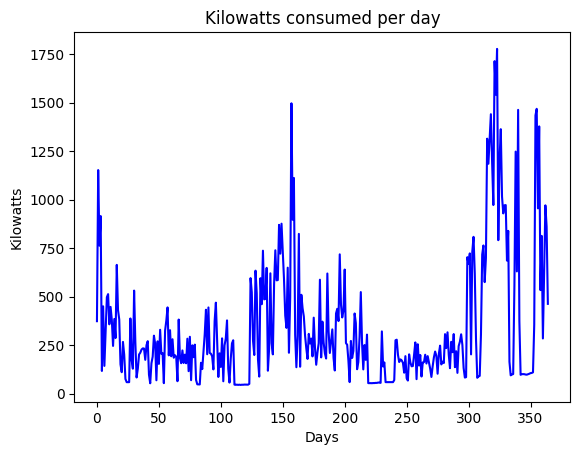

In [80]:
plt.plot(df['value'], color='blue', label='Daily Kilowatt Consumption')
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("Kilowatts consumed per day")
plt.show()

In [7]:
train_df=df[:int(len(df)*0.8)]
train_df

,value
0,373.511802
1,1152.774339
2,763.151521
3,915.743744
4,116.932079
...,...
287,213.577184
288,307.080361
289,136.363491
290,218.396137


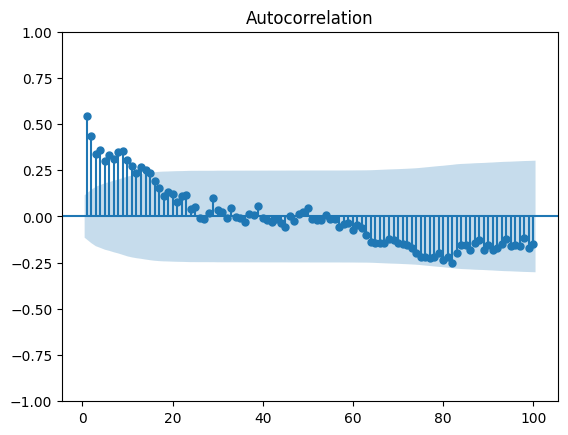

In [8]:
plot_acf(train_df, lags=100, zero=False);

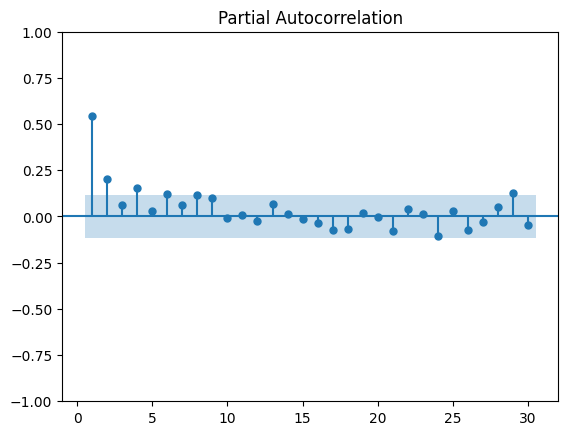

In [9]:
plot_pacf(train_df, lags=30, zero=False);

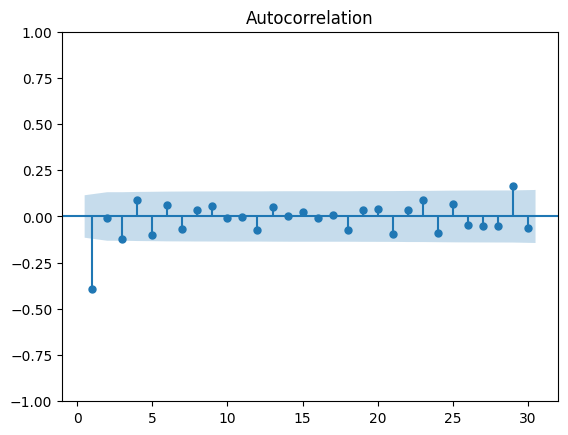

In [84]:
plot_acf(np.diff(train_df['value'], 1), lags=30, zero=False);

In [16]:
test_df=df[len(train_df):]
test_df

,value
292,245.044043
293,268.248837
294,305.849656
295,251.187570
296,132.304988
...,...
360,284.405375
361,619.278530
362,970.876859
363,860.714743


In [10]:
window_size = 7

numbers_series = pd.Series(train_df['value'])
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7=np.array(ts7)
print(ts7)

[559.31849014 551.36679881 457.71603693 421.99622389 342.23384433
 389.41622533 379.45540015 394.16724594 403.72404207 373.62793549
 395.1668713  405.64340642 396.45688755 363.69193021 344.33047423
 327.45960441 315.22002888 231.14662508 178.05329773 131.77726449
 118.63980712 158.22798375 144.80748958 134.48221483 199.60604509
 228.89993569 232.36578641 242.36179014 215.81852131 221.28726048
 235.38571615 192.82470001 188.3168602  201.31820066 218.57300445
 228.3726267  212.16339567 187.31954602 176.39964264 170.41036272
 188.20515695 189.30025688 160.50309488 185.08579631 199.35430929
 223.98280872 226.08840619 213.25643138 184.18500941 220.68385267
 235.95387622 277.57467732 258.72374629 276.10006713 273.76060284
 306.103333   286.21257148 260.68520764 224.32169412 205.28042879
 213.11781789 211.90781878 194.26852239 199.64470339 193.95817133
 195.51986513 208.7304031  194.63493375 184.87666386 204.3410043
 182.41044284 195.41118482 193.53065022 207.2567935  176.89570764
 167.200495

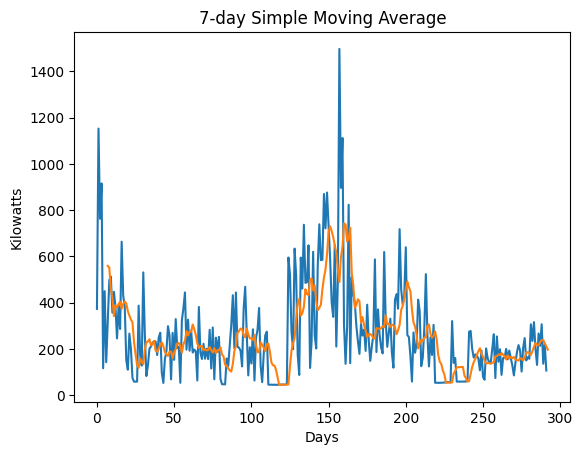

In [11]:
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("7-day Simple Moving Average")
plt.show()

In [12]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-6.967287053700811,
 8.847893561914418e-10,
 1,
 290,
 {'1%': -3.453102162983312,
  '5%': -2.871558538275452,
  '10%': -2.5721082282996433},
 3789.1342054698443)

In [96]:
Arima_model = pm.auto_arima(
    train_df,
    start_p=1, max_p=5,
    start_q=1, max_q=5,
    d=None,           # Let model choose non-seasonal differencing
    D=1,             # Force seasonal differencing
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    m=24,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    scoring="mse",   # Optimize for forecast accuracy
    n_fits=50        # Increase search iterations
)



c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be rem

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=3.69 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=3796.576, Time=0.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=3652.444, Time=1.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=3795.734, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=3730.106, Time=0.05 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=3632.556, Time=2.93 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=88.01 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=3.23 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=3729.996, Time=2.34 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=3622.802, Time=97.24 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[24] intercept   : AIC=3645.398, Time=2.82 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=6.93 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=3.56 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,1,0)[24] intercept   : AIC=3619.386, Time=8.75 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,0)[24] intercept   : AIC=3640.378, Time=3.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=9.11 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=4.60 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(2,1,0)[24] intercept   : AIC=3615.068, Time=8.97 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,1,0)[24] intercept   : AIC=3637.590, Time=2.06 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=11.65 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=4.74 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(2,1,0)[24] intercept   : AIC=3617.065, Time=10.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(2,1,0)[24] intercept   : AIC=3616.414, Time=13.77 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,1,0)[24] intercept   : AIC=3613.823, Time=13.61 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,1,0)[24] intercept   : AIC=3635.065, Time=4.55 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,1,1)[24] intercept   : AIC=inf, Time=14.96 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=5.30 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[24] intercept   : AIC=3608.733, Time=11.44 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[24] intercept   : AIC=3633.179, Time=2.73 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,1)[24] intercept   : AIC=inf, Time=12.05 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=4.47 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=3611.252, Time=6.42 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[24] intercept   : AIC=3616.882, Time=11.38 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,0)[24] intercept   : AIC=3608.882, Time=11.76 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,1,0)[24] intercept   : AIC=inf, Time=14.08 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[24]             : AIC=3607.110, Time=5.91 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[24]             : AIC=3631.578, Time=1.17 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,1)[24]             : AIC=inf, Time=9.73 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,1)[24]             : AIC=inf, Time=3.96 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[24]             : AIC=3609.697, Time=3.32 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[24]             : AIC=3621.403, Time=3.32 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,1,0)[24]             : AIC=3609.086, Time=7.55 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[24]             : AIC=inf, Time=8.54 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[24]             : AIC=3631.326, Time=1.76 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,0)[24]             : AIC=3607.274, Time=5.76 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,1,0)[24]             : AIC=3617.918, Time=2.09 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,1,0)[24]             : AIC=inf, Time=10.55 sec

Best model:  ARIMA(2,0,1)(2,1,0)[24]          
Total fit time: 466.854 seconds


In [97]:
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  292
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 24)   Log Likelihood               -1797.555
Date:                             Wed, 11 Jun 2025   AIC                           3607.110
Time:                                     16:10:47   BIC                           3628.656
Sample:                                          0   HQIC                          3615.764
                                             - 292                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1555      0.093     12.450      0.000       0.974       1.337
ar.L2         -0.1893      0.082     -2.308      0.021      -0.350      -0.029
ma.L1         -0.7882      0.065    -12.209      0.000      -0.915      -0.662
ar.S.L24      -0.7069      0.047    -14.911      0.000      -0.800      -0.614
ar.S.L48      -0.3119      0.053     -5.847      0.000      -0.416      -0.207
sigma2      3.747e+04   2127.221     17.616      0.000    3.33e+04    4.16e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               162.05
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.54
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
# Predict for the same number of periods as test data
prediction = Arima_model.predict(n_periods=len(test_df))
prediction = np.array(prediction)

c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [90]:
prediction

array([186.50955366, 204.83099229, 210.71743998, 214.0078061 ,
       216.6903786 , 219.16961382, 221.53033015, 223.79273692,
       225.96388607, 228.04805632, 230.0488528 , 231.96963506,
       233.81360788, 235.58384375, 237.28329147, 238.91478175,
       240.48103209, 241.98465129, 243.42814385, 244.81391411,
       246.14427026, 247.4214282 , 248.64751522, 249.82457353,
       250.9545637 , 252.03936789, 253.08079298, 254.08057363,
       255.04037509, 255.96179607, 256.84637132, 257.69557422,
       258.51081924, 259.29346429, 260.04481296, 260.76611675,
       261.45857708, 262.12334735, 262.76153481, 263.37420247,
       263.96237081, 264.52701951, 265.06908906, 265.58948237,
       266.08906622, 266.56867273, 267.02910077, 267.47111723,
       267.89545836, 268.30283096, 268.69391357, 269.06935759,
       269.42978838, 269.77580627, 270.10798762, 270.42688573,
       270.73303175, 271.02693562, 271.30908688, 271.57995549,
       271.83999262, 272.0896314 , 272.32928764, 272.55

In [91]:
mse = mean_squared_error(test_df, prediction)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 621.012940


In [92]:
np.mean(test_df)

639.0442539354539

In [93]:
# Create comparison arrays
test_actual = test_df['value'].values
test_predictions = prediction.flatten()

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': test_actual,
    'Predictions': test_predictions
})

print("Test Data Comparison:")
print(comparison_df)

Test Data Comparison:
        Actual  Predictions
0   245.044043   186.509554
1   268.248837   204.830992
2   305.849656   210.717440
3   251.187570   214.007806
4   132.304988   216.690379
..         ...          ...
68  284.405375   273.578864
69  619.278530   273.758968
70  970.876859   273.931871
71  860.714743   274.097860
72  462.962759   274.257211

[73 rows x 2 columns]


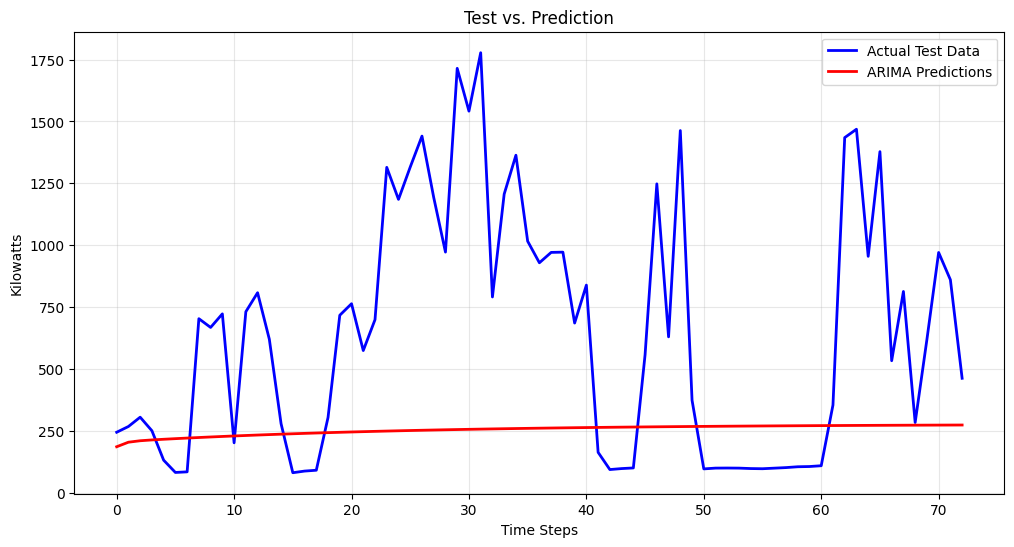

In [94]:
plt.figure(figsize=(12, 6))
# Reset test_df index to start from 0 to match prediction indices
plt.plot(test_df['value'].values, label='Actual Test Data', color='blue', linewidth=2)
plt.plot(prediction, label='ARIMA Predictions', color='red', linewidth=2)
plt.xlabel('Time Steps')
plt.ylabel('Kilowatts')
plt.title("Test vs. Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Daily Forecast

In [18]:
# Convert 'timestamp' to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Set datetime as index for resampling
df.set_index('datetime', inplace=True)

# Resample to daily sum of 'value' in kilowatts (kWh)
daily_df = df.resample('1D').sum(numeric_only=True)
daily_df['value'] = daily_df['value'] / 1000  # Convert from Wh to kWh

# Reset index to turn datetime back into a column
daily_df = daily_df.reset_index()

# Add iteration column
daily_df['iteration'] = range(len(daily_df))

# Reorder columns
daily_df = daily_df[['iteration', 'datetime', 'value']]

# Final result
print(daily_df)

     iteration   datetime        value
0            0 2022-09-01  1075.340479
1            1 2022-09-02  3319.990097
2            2 2022-09-03  2197.876380
3            3 2022-09-04  2637.341984
4            4 2022-09-05   336.764387
..         ...        ...          ...
360        360 2023-08-27   819.087481
361        361 2023-08-28  1783.522167
362        362 2023-08-29  2796.125353
363        363 2023-08-30  2478.858460
364        364 2023-08-31  1331.943858

[365 rows x 3 columns]


In [19]:
tseries= daily_df.drop('datetime', axis=1)
tseries = tseries.drop('iteration', axis=1)
df=pd.DataFrame(tseries)
df

,value
0,1075.340479
1,3319.990097
2,2197.876380
3,2637.341984
4,336.764387
...,...
360,819.087481
361,1783.522167
362,2796.125353
363,2478.858460


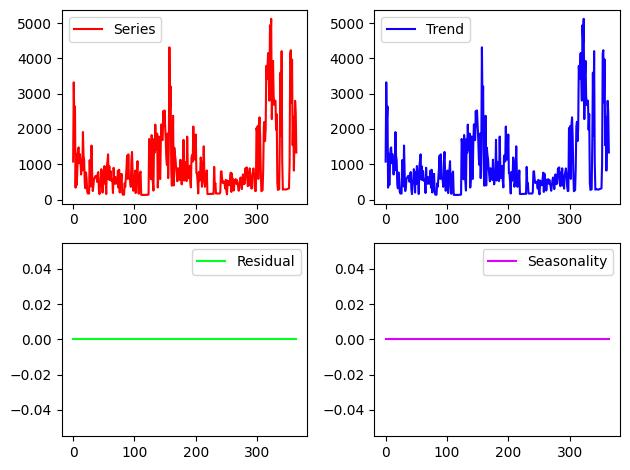

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(df['value'], model='additive', period=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(df['value'],color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

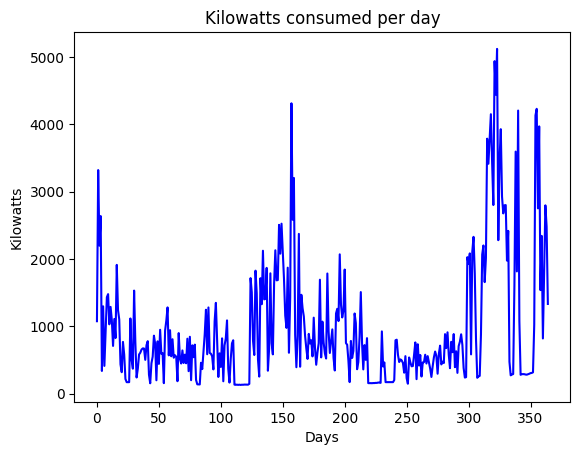

In [ ]:
plt.plot(df['value'], color='blue', label='Daily Kilowatt Consumption')
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("Kilowatts consumed per day")
plt.show()

In [21]:
train_df=df[:int(len(df)*0.8)]
train_df

,value
0,1075.340479
1,3319.990097
2,2197.876380
3,2637.341984
4,336.764387
...,...
287,615.102290
288,884.391439
289,392.726855
290,628.325686


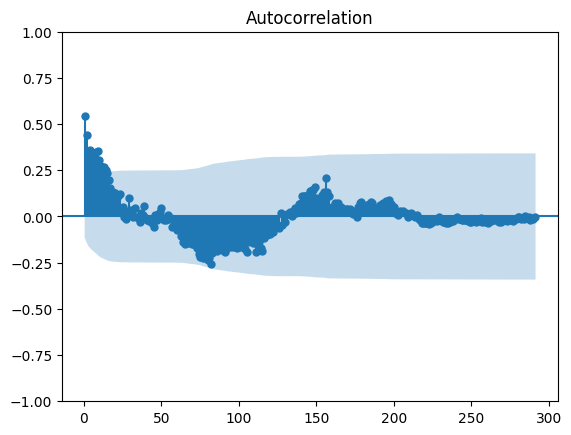

In [ ]:
plot_acf(train_df, lags=291, zero=False);

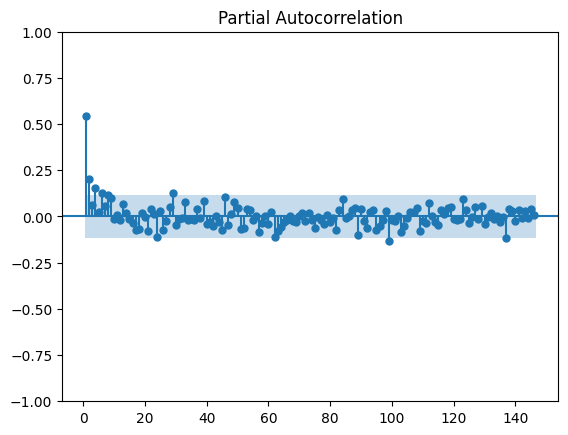

In [ ]:
plot_pacf(train_df, lags=146, zero=False);

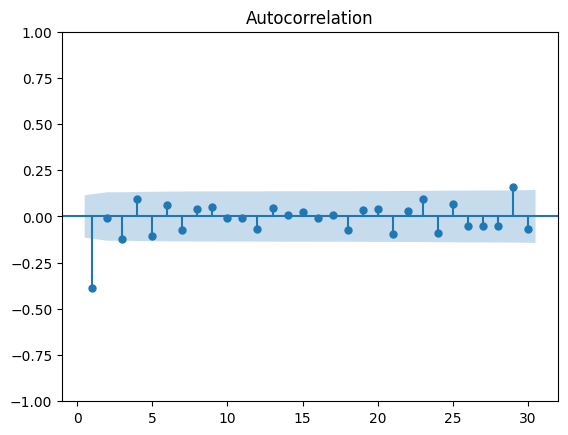

In [ ]:
plot_acf(np.diff(train_df['value'], 1), lags=30, zero=False);

In [ ]:
# Examine ACF values to find optimal window size
from statsmodels.tsa.stattools import acf

# Calculate ACF values
acf_values = acf(train_df['value'], nlags=30, fft=False)

# Find where ACF drops below significance threshold (typically 0.2 or confidence interval)
significant_lags = []
for i, val in enumerate(acf_values[1:], 1):  # Skip lag 0
    if abs(val) > 0.2:  # Adjust threshold as needed
        significant_lags.append(i)

print(f"Significant lags: {significant_lags}")
print(f"Suggested window size based on last significant lag: {max(significant_lags) if significant_lags else 7}")

# For energy consumption data, common window sizes are:
# - 7 days (weekly pattern)
# - 14 days (bi-weekly)
# - 30 days (monthly)

Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Suggested window size based on last significant lag: 15


In [22]:
test_df=df[len(train_df):len(df)]
test_df

,value
292,705.726843
293,772.556652
294,880.847010
295,723.420203
296,381.038365
...,...
360,819.087481
361,1783.522167
362,2796.125353
363,2478.858460


In [23]:
window_size = 7

# Extract the 'value' column as a Series
numbers_series = train_df['value']
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7 = np.array(ts7)
print(ts7)

[1610.78389276 1587.84556631 1318.1313721  1215.25831052  985.54265738
 1121.42791467 1092.74073817 1135.11085402 1162.72524117 1076.04845421
 1138.08058936 1168.2530105  1141.79583614 1047.432759    991.67176579
  943.08366071  907.83368317  665.70228024  512.79349745  379.51852174
  341.6826445   455.69659321  417.04557     387.30877871  574.86540986
  659.23181479  669.21346486  697.90978329  621.46516907  637.21513786
  677.81869021  555.24296371  542.26038507  579.679354    629.46536121
  657.68827329  611.00568793  539.45540093  508.00607921  490.75695302
  542.03085202  545.1847398   462.24891327  533.04709337  574.14041077
  645.07048912  651.13460981  614.17852238  530.45282711  635.56949568
  679.5471635   799.41507068  745.12438932  795.16819332  788.43053618
  881.57759904  824.29220586  750.773398    646.04647907  591.20763493
  585.08210136  579.54551713  528.02701943  543.51042072  527.13320838
  531.63088653  569.67723588  557.77949831  531.72746782  588.50209238
  525.

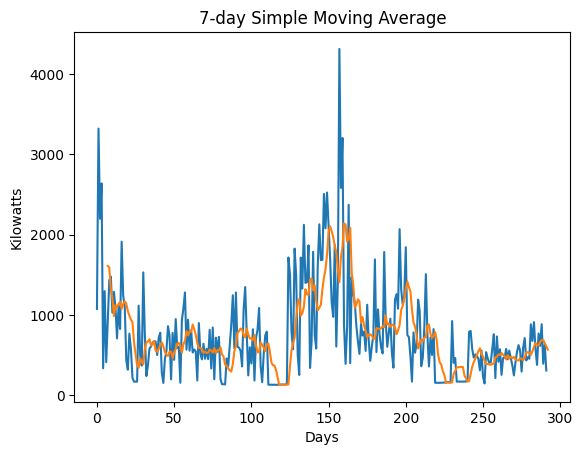

In [ ]:
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("7-day Simple Moving Average")
plt.show()

In [24]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-6.95247135941813,
 9.613967242098086e-10,
 1,
 290,
 {'1%': -3.453102162983312,
  '5%': -2.871558538275452,
  '10%': -2.5721082282996433},
 4401.2265604195545)

In [25]:
Arima_model=pm.auto_arima(train_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=15, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[15]             : AIC=4464.463, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[15]             : AIC=4351.229, Time=0.41 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[15]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[15]             : AIC=4421.515, Time=0.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[15]             : AIC=4336.470, Time=0.78 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[15]             : AIC=4324.204, Time=1.75 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(4,1,0)[15]             : AIC=4317.608, Time=3.90 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(5,1,0)[15]             : AIC=4310.075, Time=10.36 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(6,1,0)[15]             : AIC=4311.641, Time=29.45 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(5,1,1)[15]             : AIC=inf, Time=20.69 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(4,1,1)[15]             : AIC=inf, Time=8.09 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(6,1,1)[15]             : AIC=inf, Time=42.72 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(5,1,0)[15]             : AIC=4352.121, Time=1.74 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(5,1,0)[15]             : AIC=4298.386, Time=16.73 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(4,1,0)[15]             : AIC=4305.178, Time=4.03 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(6,1,0)[15]             : AIC=4300.260, Time=13.51 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(5,1,1)[15]             : AIC=inf, Time=22.99 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(4,1,1)[15]             : AIC=inf, Time=8.99 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(6,1,1)[15]             : AIC=inf, Time=45.28 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(5,1,0)[15]             : AIC=4282.793, Time=9.74 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(4,1,0)[15]             : AIC=4290.668, Time=5.65 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(6,1,0)[15]             : AIC=4283.972, Time=24.43 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(5,1,1)[15]             : AIC=inf, Time=28.59 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(4,1,1)[15]             : AIC=inf, Time=11.65 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(6,1,1)[15]             : AIC=inf, Time=47.00 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(5,1,0)[15]             : AIC=4282.805, Time=13.23 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(5,1,0)[15]             : AIC=4266.924, Time=13.24 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(4,1,0)[15]             : AIC=4276.121, Time=15.29 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(6,1,0)[15]             : AIC=4267.884, Time=31.02 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(5,1,1)[15]             : AIC=inf, Time=26.13 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(4,1,1)[15]             : AIC=inf, Time=19.30 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(6,1,1)[15]             : AIC=inf, Time=46.81 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(5,1,0)[15]             : AIC=4265.996, Time=15.50 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(4,1,0)[15]             : AIC=4274.793, Time=7.30 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(6,1,0)[15]             : AIC=4267.297, Time=23.25 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(5,1,1)[15]             : AIC=4265.715, Time=27.15 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(4,1,1)[15]             : AIC=inf, Time=14.08 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(6,1,1)[15]             : AIC=inf, Time=40.62 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(5,1,2)[15]             : AIC=inf, Time=29.01 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(4,1,2)[15]             : AIC=inf, Time=15.01 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(6,1,2)[15]             : AIC=inf, Time=49.28 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(5,1,1)[15]             : AIC=inf, Time=29.18 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(5,1,1)[15]             : AIC=inf, Time=27.12 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(5,1,1)[15]             : AIC=inf, Time=26.55 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(5,1,1)[15]             : AIC=inf, Time=31.48 sec


c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(5,1,1)[15] intercept   : AIC=inf, Time=27.76 sec

Best model:  ARIMA(2,1,1)(5,1,1)[15]          
Total fit time: 887.325 seconds


In [26]:
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  292
Model:             SARIMAX(2, 1, 1)x(5, 1, 1, 15)   Log Likelihood               -2122.858
Date:                            Thu, 12 Jun 2025   AIC                           4265.715
Time:                                    16:04:25   BIC                           4301.919
Sample:                                         0   HQIC                          4280.243
                                            - 292                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2255      0.069      3.247      0.001       0.089       0.362
ar.L2          0.0112      0.054      0.209      0.835      -0.094       0.116
ma.L1         -0.8605      0.039    -22.061      0.000      -0.937      -0.784
ar.S.L15      -0.3441      0.243     -1.418      0.156      -0.820       0.131
ar.S.L30      -0.3272      0.180     -1.820      0.069      -0.680       0.025
ar.S.L45      -0.3090      0.150     -2.066      0.039      -0.602      -0.016
ar.S.L60      -0.1847      0.130     -1.426      0.154      -0.439       0.069
ar.S.L75      -0.1763      0.105     -1.679      0.093      -0.382       0.029
ma.S.L15      -0.4330      0.232     -1.869      0.062      -0.887       0.021
sigma2      2.598e+05   1.36e+04     19.138      0.000    2.33e+05    2.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               290.63
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# Predict for the same number of periods as test data
prediction = Arima_model.predict(n_periods=len(test_df))
prediction = np.array(prediction)

c:\Users\Ghada\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [31]:
len(prediction)

73

In [32]:
mse = mean_squared_error(test_df, prediction)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 2100.180876


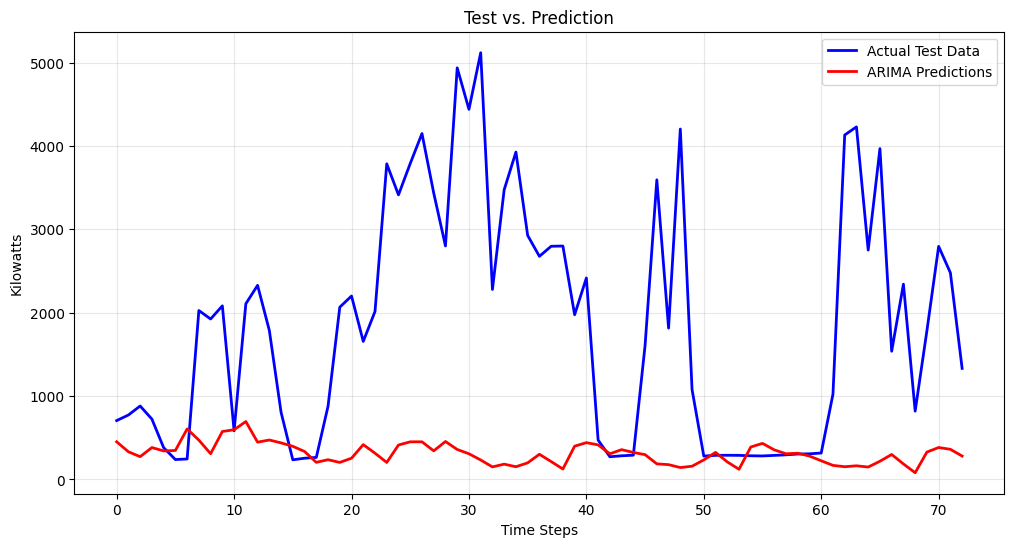

In [33]:
plt.figure(figsize=(12, 6))
# Reset test_df index to start from 0 to match prediction indices
plt.plot(test_df['value'].values, label='Actual Test Data', color='blue', linewidth=2)
plt.plot(prediction, label='ARIMA Predictions', color='red', linewidth=2)
plt.xlabel('Time Steps')
plt.ylabel('Kilowatts')
plt.title("Test vs. Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()